In [271]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [273]:
def impute_missing_values(series, k=3):
    """Impute missing values in a series using neighboring average.

    Args:
        series (pd.Series): The series with missing values.
        k (int): The number of neighboring values to use for imputation.

    Returns:
        pd.Series: The series with imputed values.
    """

    # Find the indices of the missing values.
    missing_indices = series[series.isna()].index

    # For each missing value, impute it with the average of its k nearest neighbors.
    for index in missing_indices:
        neighbors = None
        if k >= index:
            neighbors = series[0:index + k].dropna()
        else:
            neighbors = series[index-k:index + k].dropna()
        series.loc[index] = neighbors.mean()

    return series


In [275]:
"""
def create_features(sequence, n_steps):
    """ Create a dataframe from a series with n_steps lags """
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


SyntaxError: unterminated triple-quoted string literal (detected at line 15) (244629107.py, line 3)

In [277]:
def create_features(sequence, n_steps, forecast_horizon=6):
    """Create input-output pairs for 6-hour ahead forecasting"""
    X, y = [], []
    for i in range(len(sequence) - n_steps - forecast_horizon + 1):
        # Input: n_steps historical values
        seq_x = sequence[i:i+n_steps]
        # Output: Value at 6 steps ahead
        seq_y = sequence[i + n_steps + forecast_horizon - 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [279]:
def split_data(series, tr_len):
    val_len = (len(series) - tr_len) // 2
    tr_series = series[:tr_len]
    val_series = series[tr_len:(tr_len+val_len)]
    test_series = series[(tr_len+val_len):]
    return tr_series, val_series, test_series


In [281]:
from dtwi_analyzer import find_gaps, edtwbi

def impute_dtwi(arr):
    arr = pd.Series(arr).fillna(value=0).values
    filled_arr = arr.copy()
    gaps = find_gaps(arr)
    for gap in gaps:
        if gap[1] - gap[0] < 0.3*len(arr):
            filled_arr[gap[0]:gap[1]] = edtwbi(arr, gap[0], gap[1])
    return filled_arr


In [283]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


In [285]:
# lets start wirth BPNN and try lstm too 

In [287]:
import numpy as np
import matplotlib.pylab as plt
from math import *
#from sklearn.models import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook

In [289]:
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [291]:
pip install torch 

Note: you may need to restart the kernel to use updated packages.


In [293]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [295]:
import warnings
warnings.filterwarnings('ignore')

In [297]:
from sklearn.metrics import mean_squared_error as mse

In [299]:
df = pd.read_csv('2016_THUWAL_data_wide.csv')

In [301]:
df

,date,hour,lon,lat,dniuncer,ghiuncer,t2,wd3m,ws3m,swddhi,swddni,ghi,rh2,sfcpres,dhiuncer
0,2016-01-01,0,39.1,22.3,0.0,0.0,19.6,37.0,2.1,0.0,0.0,0.0,69.6,1013.2,0.0
1,2016-01-01,1,39.1,22.3,0.0,0.0,18.9,39.0,1.7,0.0,0.0,0.0,69.6,1013.0,0.0
2,2016-01-01,2,39.1,22.3,0.0,0.0,18.6,45.0,1.5,0.0,0.0,0.0,70.3,1013.0,0.0
3,2016-01-01,3,39.1,22.3,0.0,0.0,18.5,37.0,2.1,0.0,0.0,0.0,69.0,1012.7,0.0
4,2016-01-01,4,39.1,22.3,0.0,0.0,18.0,55.0,1.9,0.0,0.0,0.0,69.6,1012.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2016-12-31,19,39.1,22.3,0.0,0.0,24.0,313.0,2.3,0.0,0.0,0.0,80.1,1013.9,0.0
8780,2016-12-31,20,39.1,22.3,0.0,0.0,23.9,316.0,2.3,0.0,0.0,0.0,81.7,1014.2,0.0
8781,2016-12-31,21,39.1,22.3,0.0,0.0,23.9,321.0,2.0,0.0,0.0,0.0,83.3,1014.6,0.0
8782,2016-12-31,22,39.1,22.3,0.0,0.0,23.9,338.0,2.0,0.0,0.0,0.0,83.1,1014.7,0.0


In [303]:
from torch.utils.data import Dataset

class WindDataset(Dataset):
    def __init__(self, x, y):
        self.x = x  # Input features (e.g., historical wind speeds)
        self.y = y  # Target values (e.g., future wind speeds)
    
    def __len__(self):
        return len(self.x)  # Total number of samples
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]  # Returns (input, label) pair


In [305]:
import torch
import torch.nn as nn

"""
class BPNNForecast(nn.Module):
    def __init__(self, input_size=5, hidden_size=200, num_layers=1, num_classes=1):
        super(BPNNForecast, self).__init__()
        
        # Architecture configuration (preserving your parameters)
        self.input_size = input_size    # 5 input features
        self.hidden_size = hidden_size  # 200 hidden neurons
        self.num_layers = num_layers    # 1 hidden layer
        self.num_classes = num_classes  # 1 output value
        
        # Network layers
        self.flatten = nn.Flatten()
        self.input_fc = nn.Linear(input_size, hidden_size)
        self.hidden_fc = nn.Linear(hidden_size, hidden_size) if num_layers > 1 else None
        self.output_fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: [batch_size, seq_length=1, input_size=5]
        x = self.flatten(x)  # → [batch_size, input_size]
        
        x = self.relu(self.input_fc(x))
        
        if self.hidden_fc:  # Only if num_layers > 1
            x = self.relu(self.hidden_fc(x))
            
        return self.output_fc(x)
"""


'\nclass BPNNForecast(nn.Module):\n    def __init__(self, input_size=5, hidden_size=200, num_layers=1, num_classes=1):\n        super(BPNNForecast, self).__init__()\n        \n        # Architecture configuration (preserving your parameters)\n        self.input_size = input_size    # 5 input features\n        self.hidden_size = hidden_size  # 200 hidden neurons\n        self.num_layers = num_layers    # 1 hidden layer\n        self.num_classes = num_classes  # 1 output value\n        \n        # Network layers\n        self.flatten = nn.Flatten()\n        self.input_fc = nn.Linear(input_size, hidden_size)\n        self.hidden_fc = nn.Linear(hidden_size, hidden_size) if num_layers > 1 else None\n        self.output_fc = nn.Linear(hidden_size, num_classes)\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        # Input shape: [batch_size, seq_length=1, input_size=5]\n        x = self.flatten(x)  # → [batch_size, input_size]\n        \n        x = self.relu(self.input_fc(x))\

In [307]:
class BPNNForecast(nn.Module):
    def __init__(self, input_size=5, hidden_size=200, num_layers=1, output_size=1):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)  # Output 1 value for 6h ahead
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)  # [batch, 1, 5] → [batch, 5]
        x = self.relu(self.fc1(x))
        return self.fc2(x)  # Shape: [batch, 1]


In [309]:
"""
window_size = 5
train_len = int(.6*df.shape[0])
"""

'\nwindow_size = 5\ntrain_len = int(.6*df.shape[0])\n'

In [311]:
window_size = 5
forecast_horizon = 6  # Predict 6 hours ahead
train_len = int(.6 * df.shape[0])


In [314]:
"""
train_data, val_data, test_data = split_data(df.ws3m.values, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)
"""

'\ntrain_data, val_data, test_data = split_data(df.ws3m.values, train_len)\ntrain_data = np.float32(train_data)\nval_data = np.float32(val_data)\ntest_data = np.float32(test_data)\n'

In [316]:
train_data, val_data, test_data = split_data(df.ws3m.values, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

# Create features for 6-hour-ahead forecasting
xtrain, ytrain = create_features(train_data, window_size, forecast_horizon)
xval, yval = create_features(val_data, window_size, forecast_horizon)
xtest, ytest = create_features(test_data, window_size, forecast_horizon)


In [318]:
train_data.shape

(5270,)

In [320]:
val_data.shape

(1757,)

In [322]:
test_data.shape

(1757,)

In [324]:
"""
xtrain, ytrain = create_features(train_data, window_size)
xval, yval = create_features(val_data, window_size)
xtest, ytest = create_features(test_data, window_size)

"""

'\nxtrain, ytrain = create_features(train_data, window_size)\nxval, yval = create_features(val_data, window_size)\nxtest, ytest = create_features(test_data, window_size)\n\n'

In [326]:
train = WindDataset(xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1]), ytrain)
valid = WindDataset(xval.reshape(xval.shape[0], 1, xval.shape[1]), yval)
test = WindDataset(xtest.reshape(xtest.shape[0], 1, xtest.shape[1]), ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [329]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize your BPNN model
model = BPNNForecast(
    input_size=5,        # Number of input features
    hidden_size=200,     # Number of neurons in hidden layer
    num_layers=1,        # Number of hidden layers
    output_size=1        # Output size
).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()


In [331]:
for p in model.parameters():
    print(p.shape)

torch.Size([200, 5])
torch.Size([200])
torch.Size([1, 200])
torch.Size([1])


In [333]:
NUM_EPOCHS = 200

In [335]:
train_losses = []
valid_losses = []

def Train():
    model.train()
    running_loss = 0.0  # Use float instead of tensor
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  # Convert tensor to float
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Train Loss: {train_loss:.4f}')

def Valid():
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            preds = model(inputs)
            loss = criterion(preds, labels)
            running_loss += loss.item()  # Convert tensor to float
    
    valid_loss = running_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    print(f'Valid Loss: {valid_loss:.4f}')


In [337]:
for epoch in range(NUM_EPOCHS):
    print('epochs {}/{}'.format(epoch+1, NUM_EPOCHS))
    Train()
    Valid()
    gc.collect()

epochs 1/200
Train Loss: 3.7169
Valid Loss: 2.8780
epochs 2/200
Train Loss: 2.7511
Valid Loss: 2.6385
epochs 3/200
Train Loss: 2.5334
Valid Loss: 2.4419
epochs 4/200
Train Loss: 2.3591
Valid Loss: 2.2867
epochs 5/200
Train Loss: 2.2162
Valid Loss: 2.1547
epochs 6/200
Train Loss: 2.0952
Valid Loss: 2.0437
epochs 7/200
Train Loss: 1.9924
Valid Loss: 1.9483
epochs 8/200
Train Loss: 1.9042
Valid Loss: 1.8666
epochs 9/200
Train Loss: 1.8292
Valid Loss: 1.7980
epochs 10/200
Train Loss: 1.7678
Valid Loss: 1.7430
epochs 11/200
Train Loss: 1.7189
Valid Loss: 1.6992
epochs 12/200
Train Loss: 1.6799
Valid Loss: 1.6643
epochs 13/200
Train Loss: 1.6489
Valid Loss: 1.6364
epochs 14/200
Train Loss: 1.6241
Valid Loss: 1.6141
epochs 15/200
Train Loss: 1.6043
Valid Loss: 1.5961
epochs 16/200
Train Loss: 1.5883
Valid Loss: 1.5816
epochs 17/200
Train Loss: 1.5754
Valid Loss: 1.5697
epochs 18/200
Train Loss: 1.5648
Valid Loss: 1.5600
epochs 19/200
Train Loss: 1.5561
Valid Loss: 1.5520
epochs 20/200
Train L

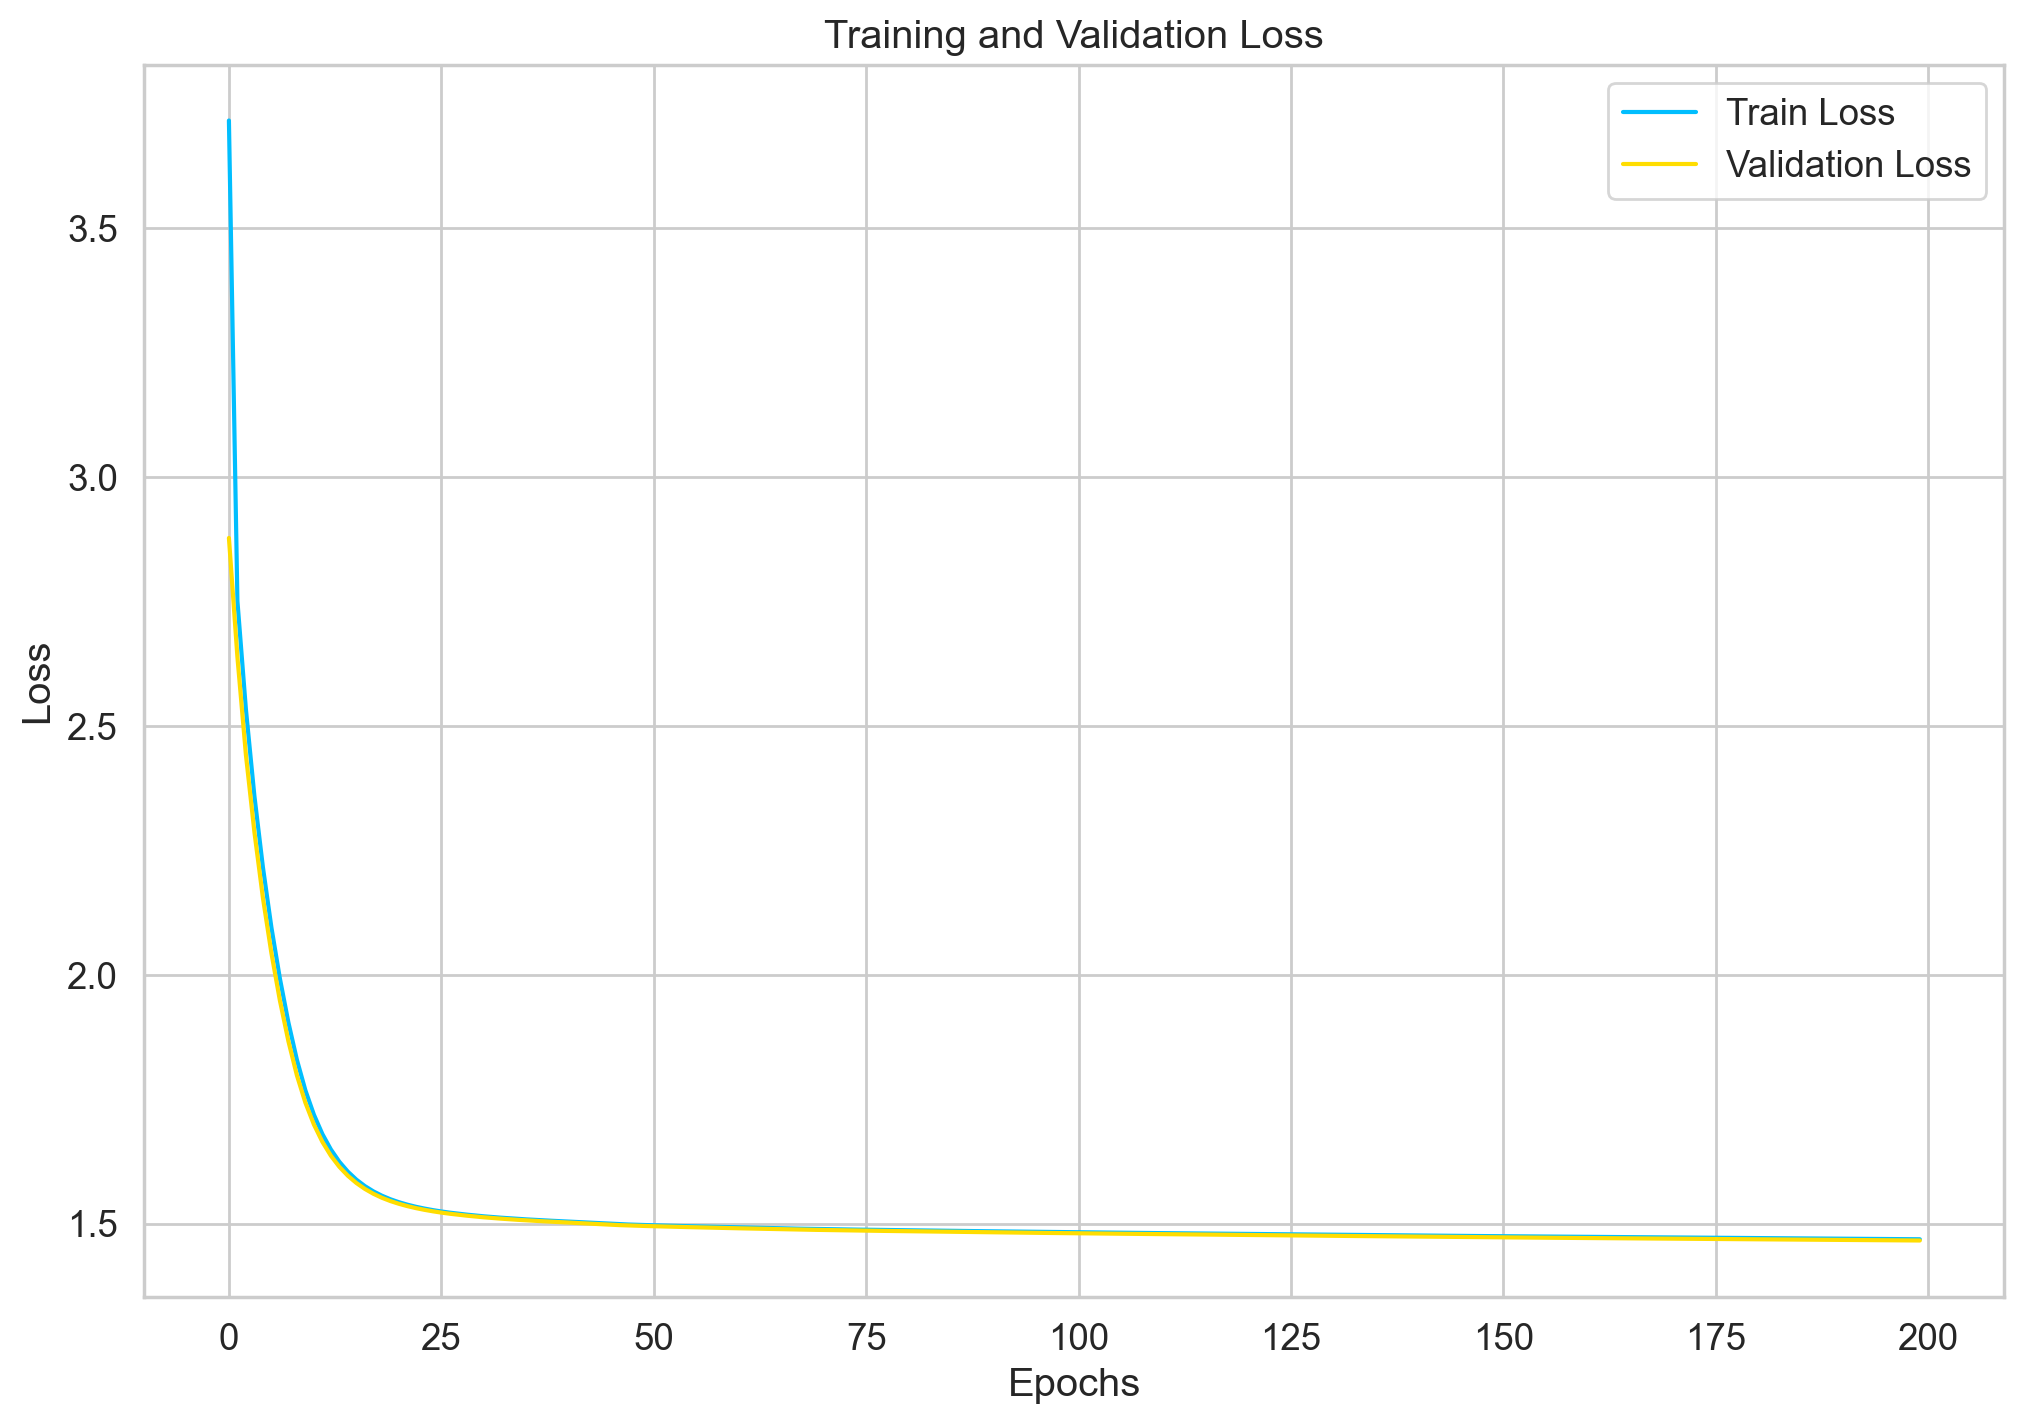

In [339]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()   # This line actually renders the plot


In [341]:
predictions = []
test_losses = []
running_loss = 0.
model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model.forward(inputs)
        predictions.append(preds.item())
        loss = criterion(preds,labels)
        running_loss += loss
        
    test_loss = running_loss/len(valid_loader)
    test_losses.append(test_loss.detach().numpy())

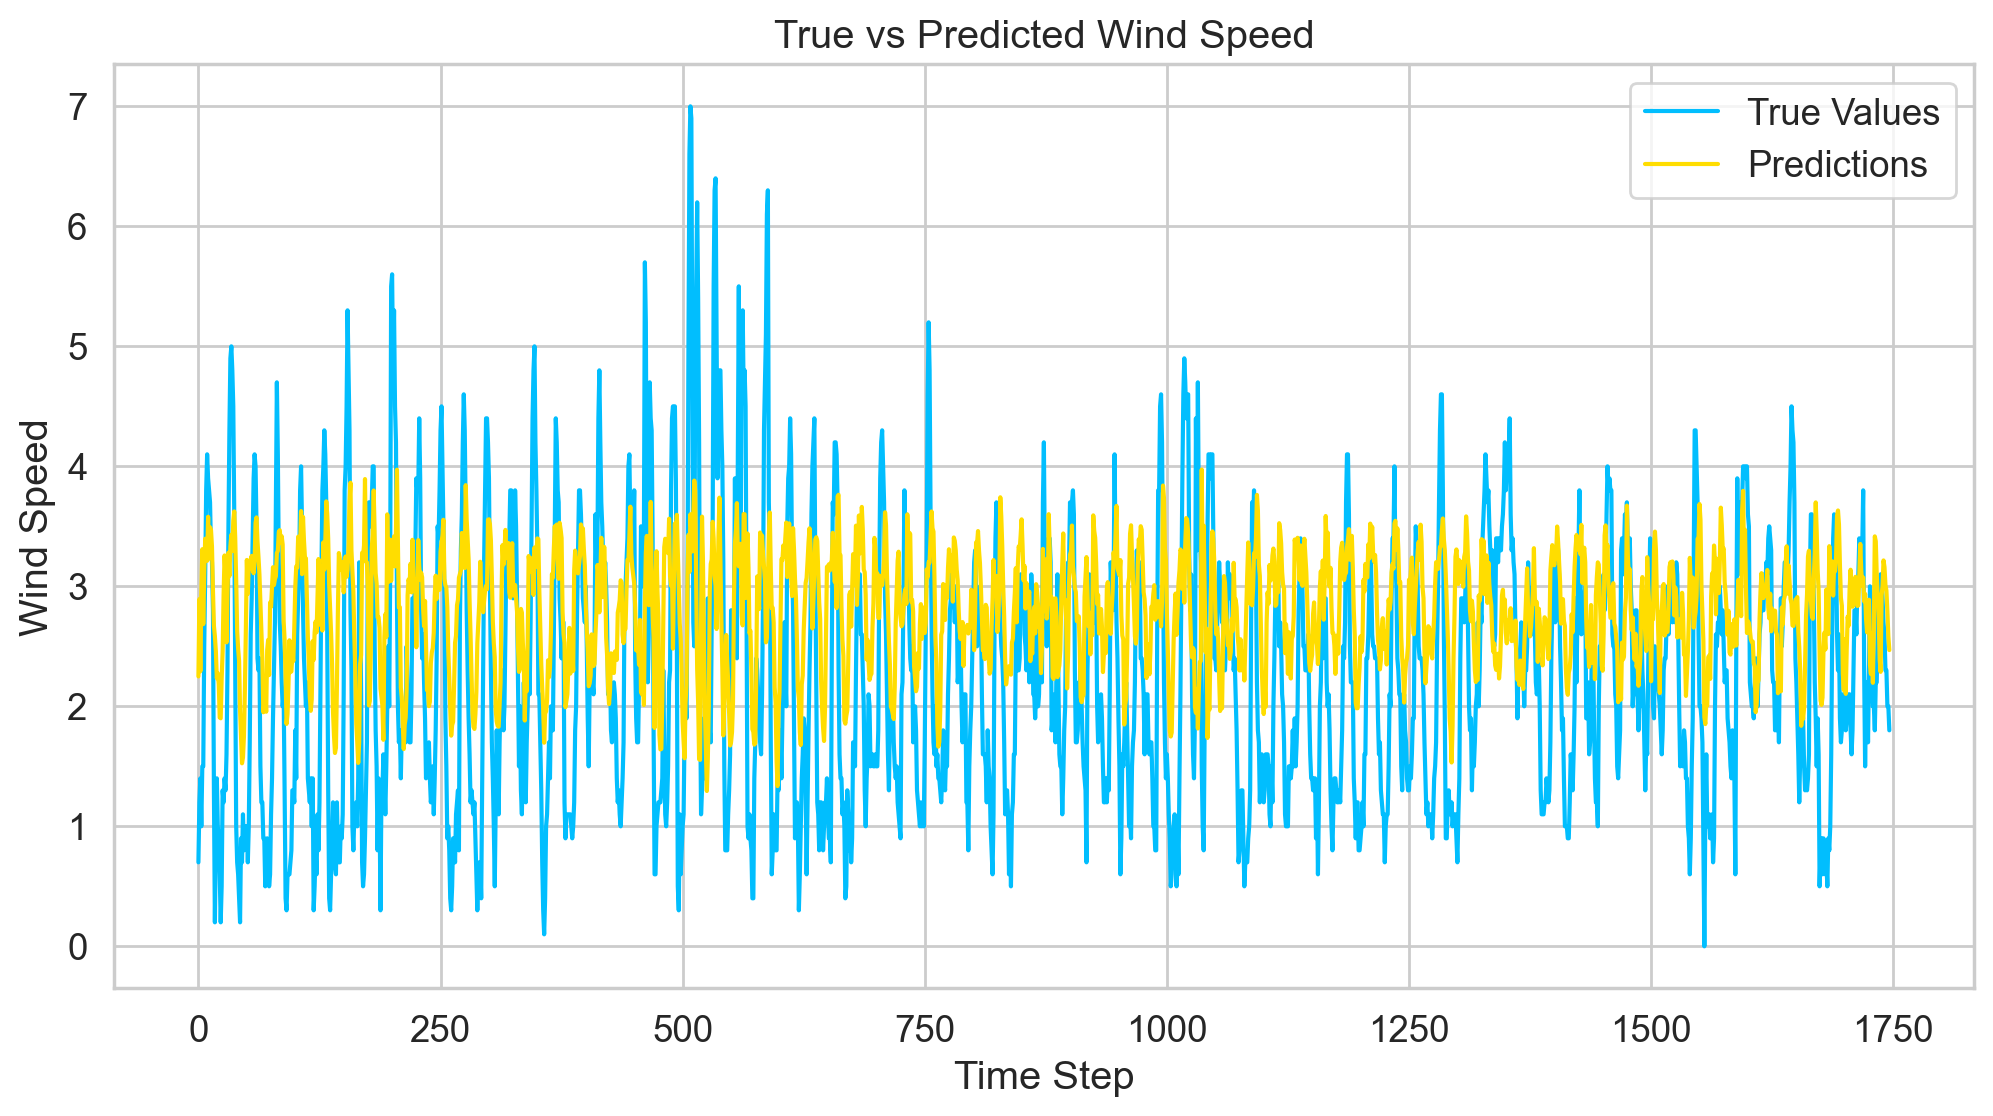

In [343]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(ytest, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time Step')
plt.ylabel('Wind Speed')
plt.title('True vs Predicted Wind Speed')
plt.legend()
plt.show()


In [345]:
mse(predictions, ytest)

1.3425464630126953